# Telco Customer Churn

In [1]:
# set task name
task_name = 'telco_churn-v2'

# load common
%run common.ipynb

Cortex Python SDK v6.2.0
Cortex Discovery Libraries v3.5.14


In [18]:
from ds_discovery import ModelsBuilder
from ds_discovery import Wrangle
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import Sequential
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score


## Model Run

In [3]:

ml = ModelsBuilder.from_env(task_name, has_contract=False)
uri = Wrangle.from_env(task_name).get_persist_contract().uri
ml.set_source_uri(uri=uri)
ml.pm_persist()

In [4]:
wr = Wrangle.from_env(task_name)
df = wr.load_persist_canonical()

In [5]:
# predictors
X = df.drop(['Churn', 'CustomerID'], axis=1)
# target
y = df['Churn']

In [ ]:
df.head()

In [ ]:
df["TotalCharges"] = df["TotalCharges"].replace(" ", 0).astype("float32")
df["Satisfaction Score"] = df["Satisfaction_Score"].astype("object")
df["SeniorCitizen"] = df["SeniorCitizen"].replace(0, "0").replace(1, "1") 

In [ ]:
df.head()

In [ ]:
X.head()
y.head()

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state = 1)

In [7]:
X_train.shape

(800, 1405)

In [15]:
X_test.shape

(200, 1405)

In [8]:
### Create Model

nn_model2 = Sequential()
nn_model2.add(layers.Dense(64, kernel_regularizer=tf.keras.regularizers.l2(0.0001),
                          input_dim=1405, activation='relu'))
##Dropout for not memorize or overfitting the train data
nn_model2.add(layers.Dropout(0.2)) 
nn_model2.add(layers.Dense(8, kernel_regularizer=tf.keras.regularizers.l2(0.0001),
                          input_dim=1405, activation='relu'))
nn_model2.add(layers.Dropout(0.1)) 
nn_model2.add(layers.Dense(1, activation='sigmoid'))

Metal device set to: Apple M1 Max

systemMemory: 64.00 GB
maxCacheSize: 24.00 GB



2022-12-15 17:02:36.854630: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-12-15 17:02:36.854864: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [9]:
# Training

lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(0.0001, 
                                                            decay_steps=(X_train.shape[0]/32)*50,
                                                            decay_rate=1,
                                                            staircase=False)
##Time decay means for every 50 epochs the learning rate will be half of 0.001 value
def get_optimizer():
    return tf.keras.optimizers.Adam(lr_schedule)
def get_callbacks():
    return
[tf.keras.callbacks.EarlyStopping(monitor="val_accuracy",
                                  patience=70, restore_best_weights=True)]

nn_model2.compile(loss='binary_crossentropy', optimizer=get_optimizer(), 
                 metrics=['accuracy'])
nn_model2.summary()

history = nn_model2.fit(X_train, y_train, validation_data = (X_test, y_test),
                       epochs = 150, batch_size=32, callbacks = get_callbacks(),
                       verbose=0)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                89984     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 8)                 520       
                                                                 
 dropout_1 (Dropout)         (None, 8)                 0         
                                                                 
 dense_2 (Dense)             (None, 1)                 9         
                                                                 
Total params: 90,513
Trainable params: 90,513
Non-trainable params: 0
_________________________________________________________________


2022-12-15 17:02:43.393408: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-12-15 17:02:43.623602: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-12-15 17:02:44.524457: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


In [10]:
warnings.filterwarnings("ignore")

<Figure size 1200x700 with 0 Axes>

Text(0.5, 1.0, 'Accuracy')

Text(0.5, 0, 'Epochen')

Text(0, 0.5, 'Accuracy')

<Figure size 640x480 with 0 Axes>

<Figure size 1200x700 with 0 Axes>

Text(0.5, 1.0, 'Loss')

Text(0.5, 0, 'Epochen')

Text(0, 0.5, 'Loss')

<function matplotlib.pyplot.figure(num=None, figsize=None, dpi=None, facecolor=None, edgecolor=None, frameon=True, FigureClass=<class 'matplotlib.figure.Figure'>, clear=False, **kwargs)>

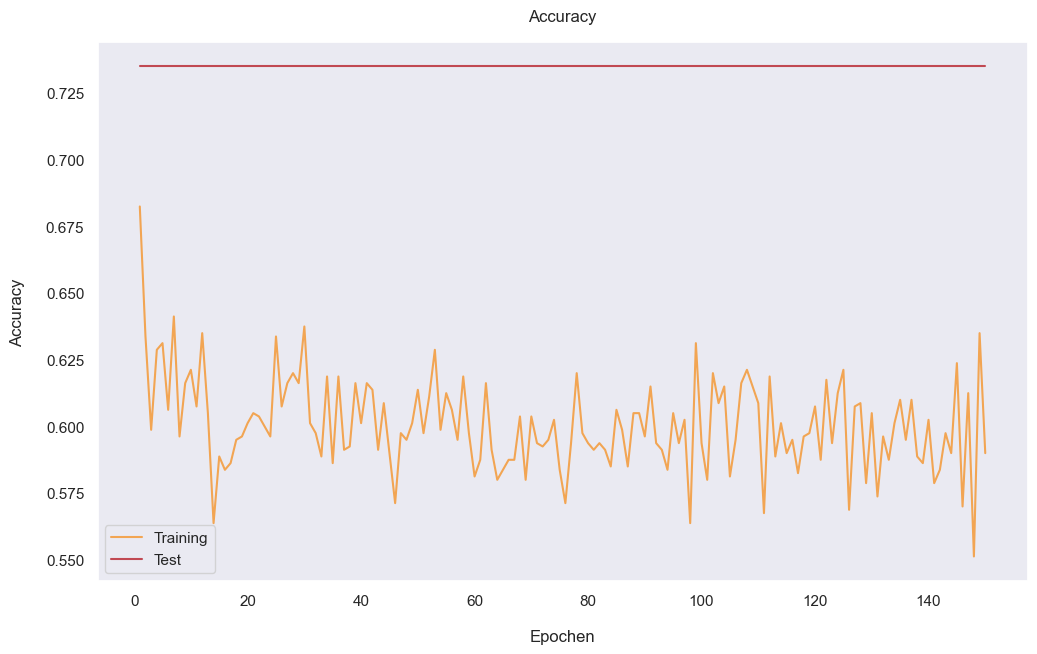

<Figure size 640x480 with 0 Axes>

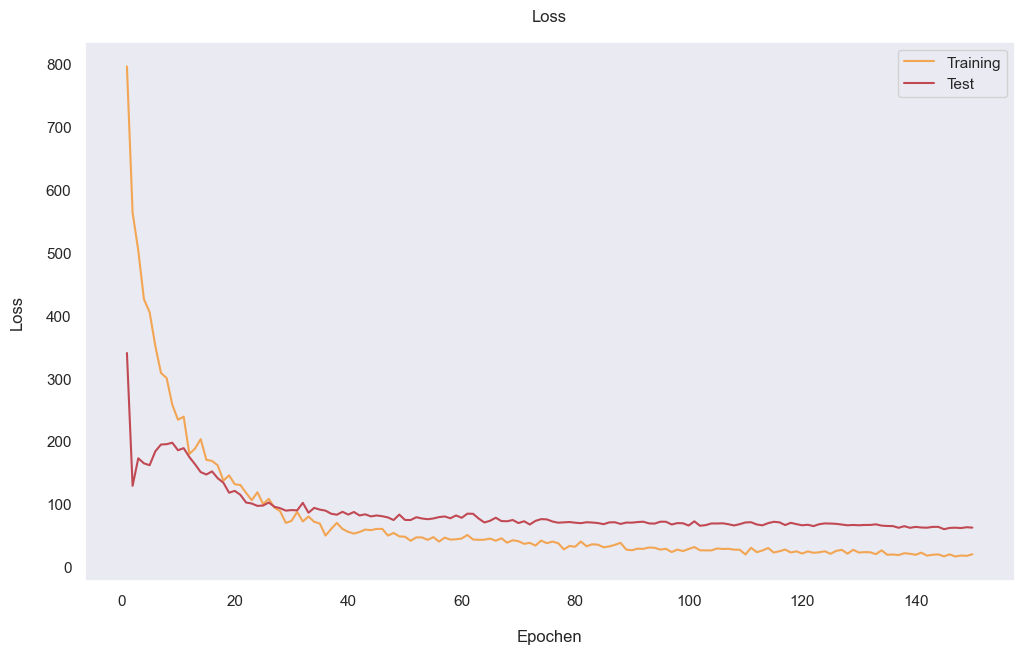

In [11]:
# Training process

acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
 
epochs = range(1, len(acc) + 1)

plt.figure(figsize=(12,7))
plt.plot(epochs, acc, color='#f2a553', label='Training')
plt.plot(epochs, val_acc, 'b', color='#c14953', label='Test')
plt.title('Accuracy', pad = 15)
plt.grid(False)
plt.xlabel('Epochen', labelpad = 15)
plt.ylabel('Accuracy', labelpad = 15)
plt.legend()
plt.figure()

plt.figure(figsize=(12,7)) 
plt.plot(epochs, loss, color='#f2a553', label='Training')
plt.plot(epochs, val_loss, 'b', color='#c14953', label='Test')
plt.title('Loss', pad = 15)
plt.grid(False)
plt.xlabel('Epochen', labelpad = 15)
plt.ylabel('Loss', labelpad = 15)
plt.legend()
plt.figure


In [12]:
# Evaluation

accuracy = nn_model2.evaluate(X_train, y_train, verbose=False)
print("Training Score: {:.4f}".format(accuracy[0]))
print("Training Accuracy: {:.4f}".format(accuracy[1]))

accuracy = nn_model2.evaluate(X_test, y_test, verbose=False)
print("Testing Score: {:.4f}".format(accuracy[0]))
print("Testing Accuracy: {:.4f}".format(accuracy[1]))


Training Score: 64.9804
Training Accuracy: 0.7250
Testing Score: 62.4529
Testing Accuracy: 0.7350


7/7 [==============================] - 0s 3ms/step


<Figure size 1200x700 with 0 Axes>

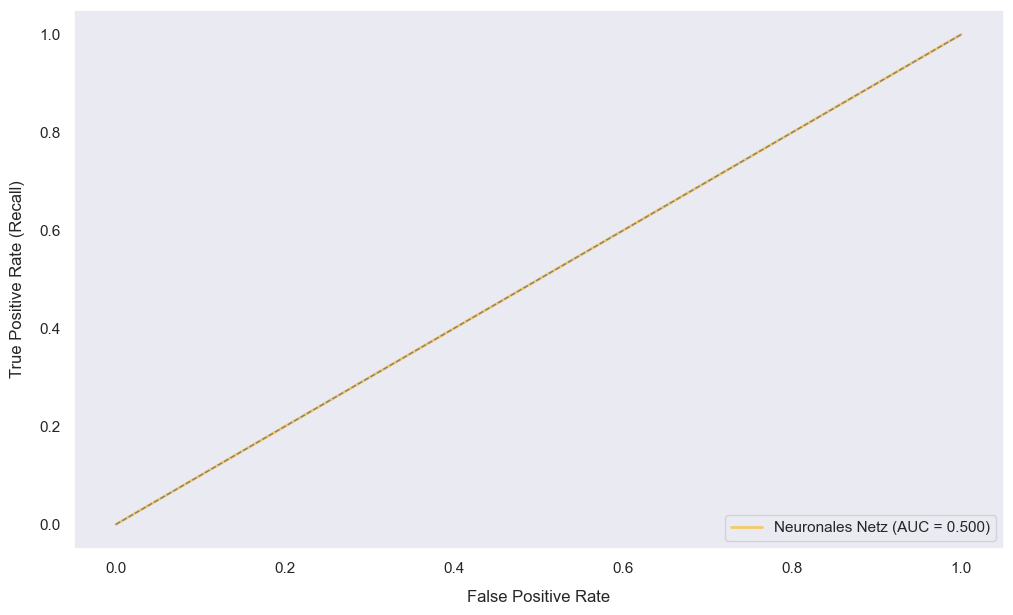

In [19]:
# make predictions for test dataset
X_test_np=X_test.to_numpy() # np = numpy
X_test_np_r=X_test_np.reshape(200,1405) # r = reshape
#print(X_test_np_r)

yprednn_r_test = nn_model2.predict(X_test_np_r)
#print(yprednn_r_test)

# ROC Curve Input NN
y_scores_nn = yprednn_r_test
fpr_nn, tpr_nn, thresholds_nn = roc_curve(y_test, y_scores_nn)

# Plot ROC Curve
plt.figure(figsize=(12,7))
def plot_roc_curve(fpr, tpr, label=None, color=None):
    plt.plot(fpr, tpr, linewidth=2, label=label, color=color)
    plt.plot([0, 1], [0, 1], 'k--', linewidth=1.0, color="gray") # Dashed diagonal
    plt.xlabel('False Positive Rate', labelpad = 10)
    plt.ylabel('True Positive Rate (Recall)', labelpad = 10)
    plt.legend(loc="lower right")
    plt.grid(False)
    
plot_roc_curve(fpr_nn, tpr_nn, "Neuronales Netz (AUC = %0.3f)" % (roc_auc_score(y_test, y_scores_nn)), "#f3c969")